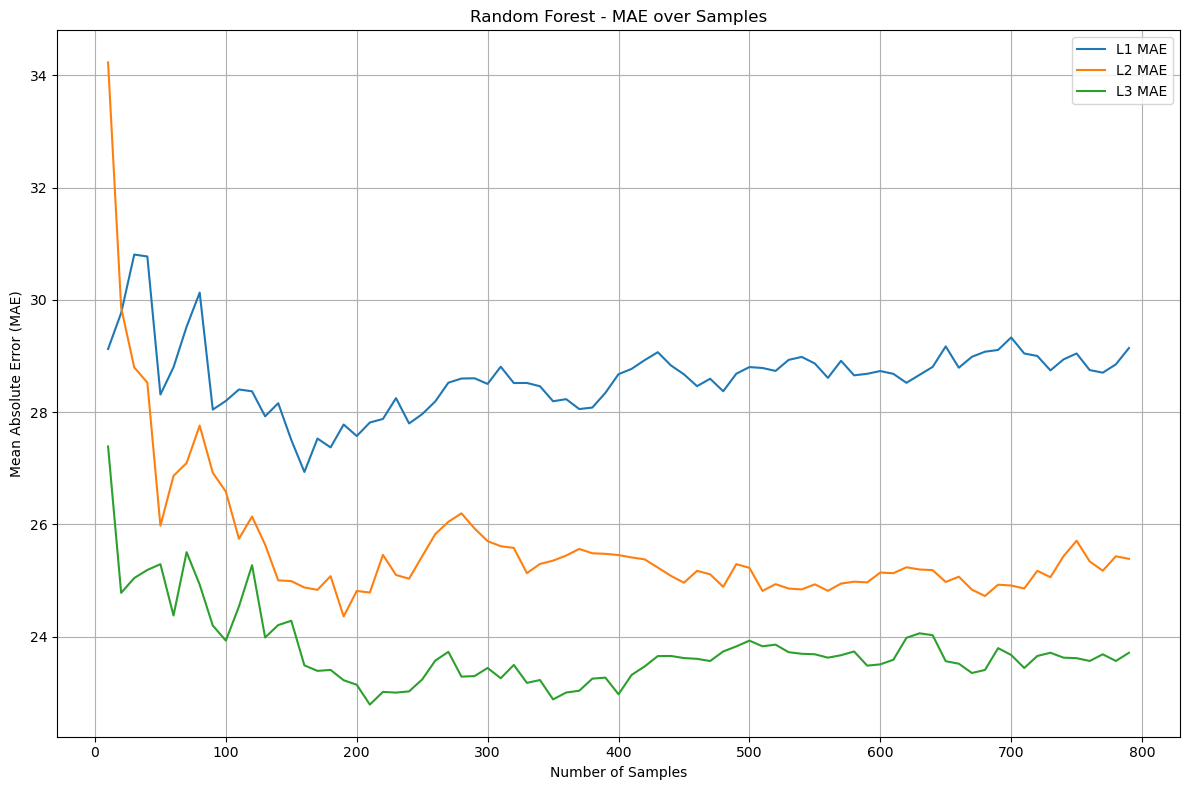

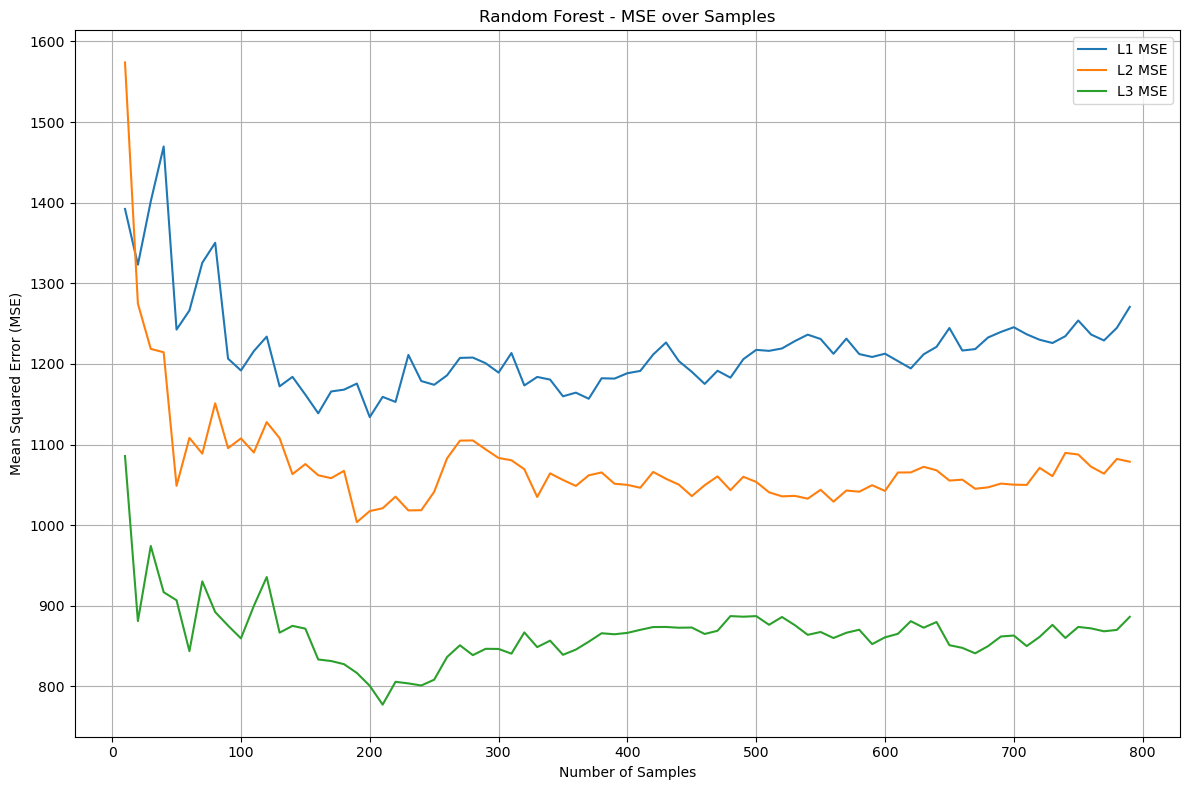

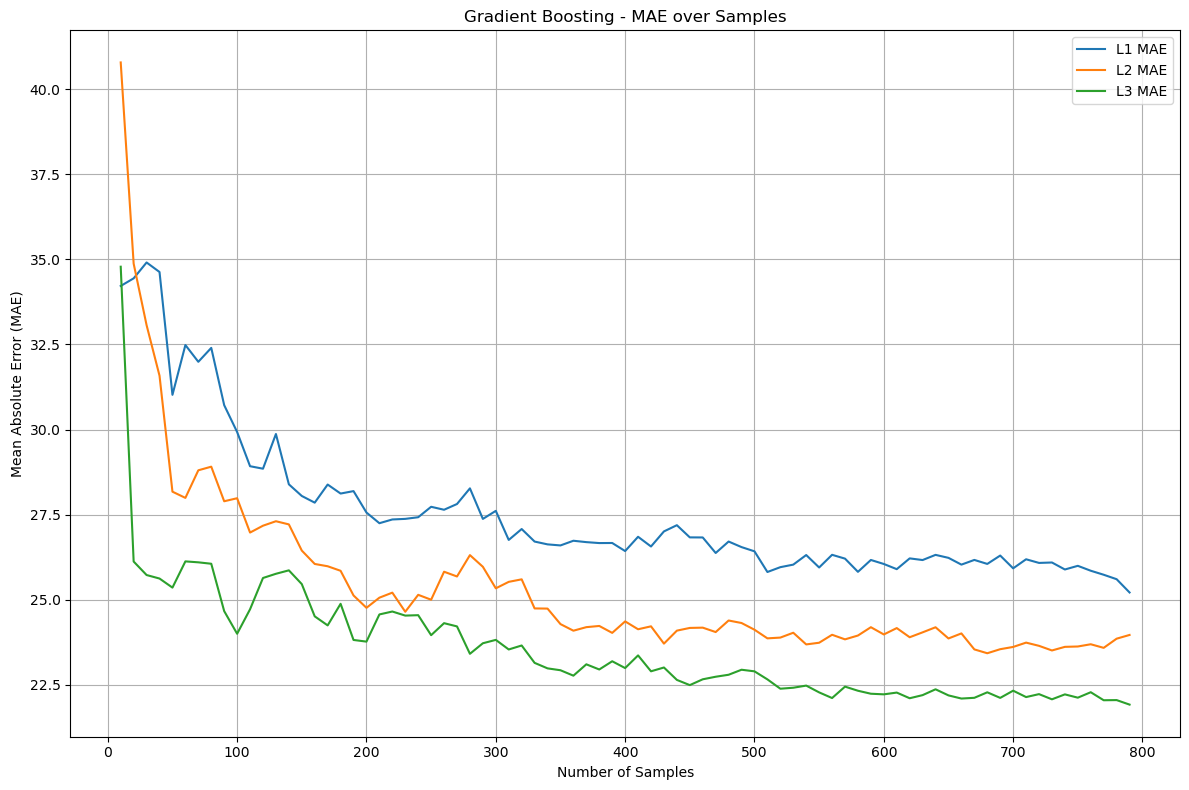

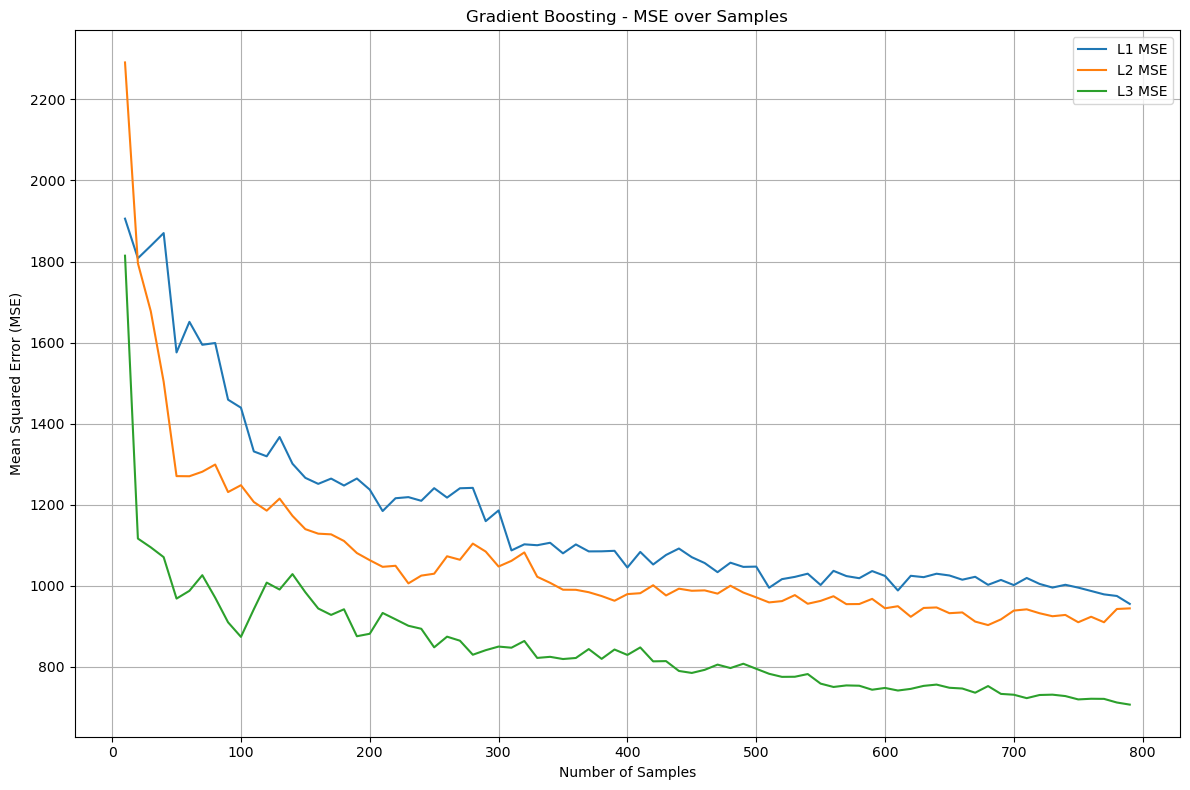

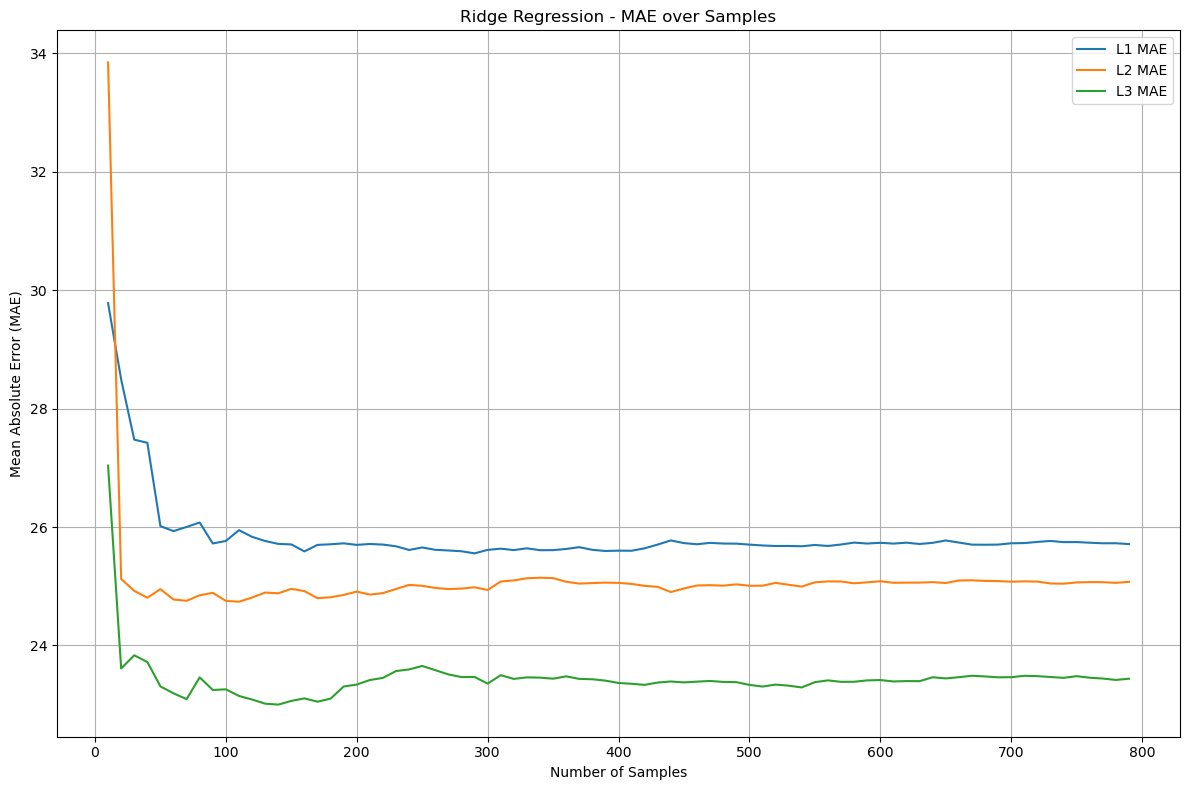

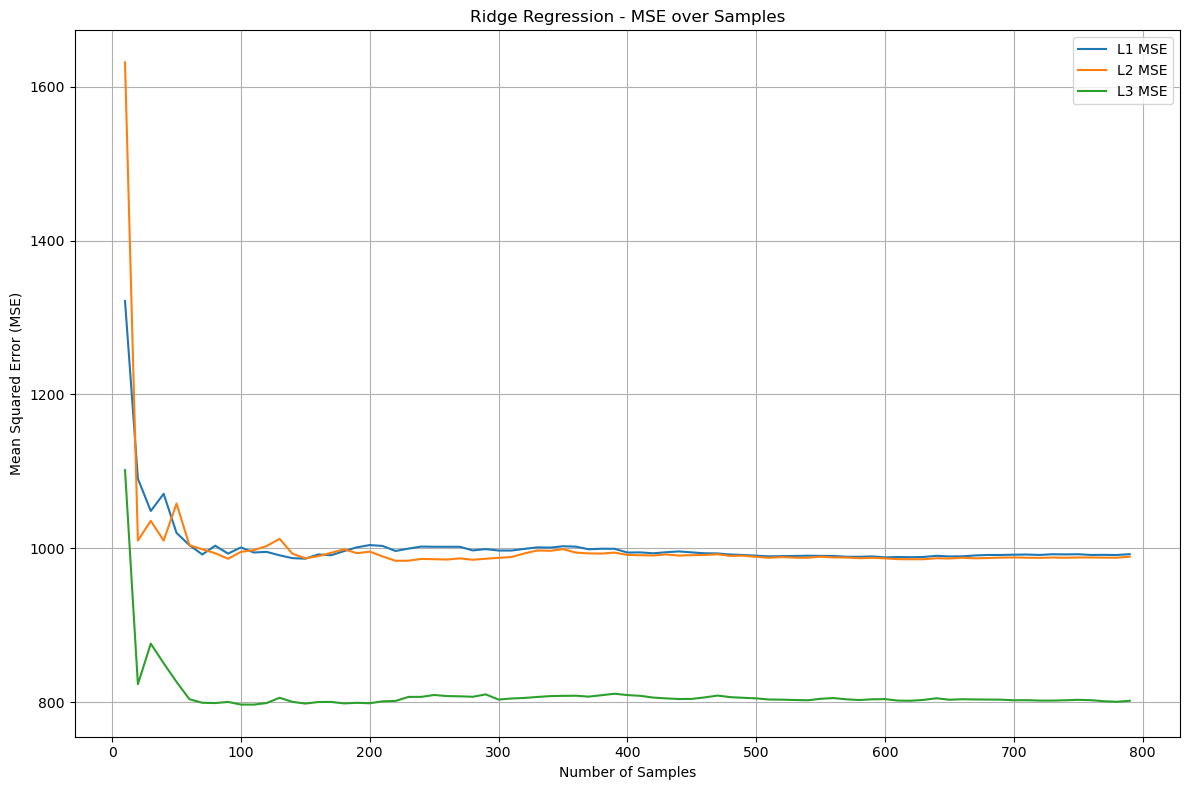

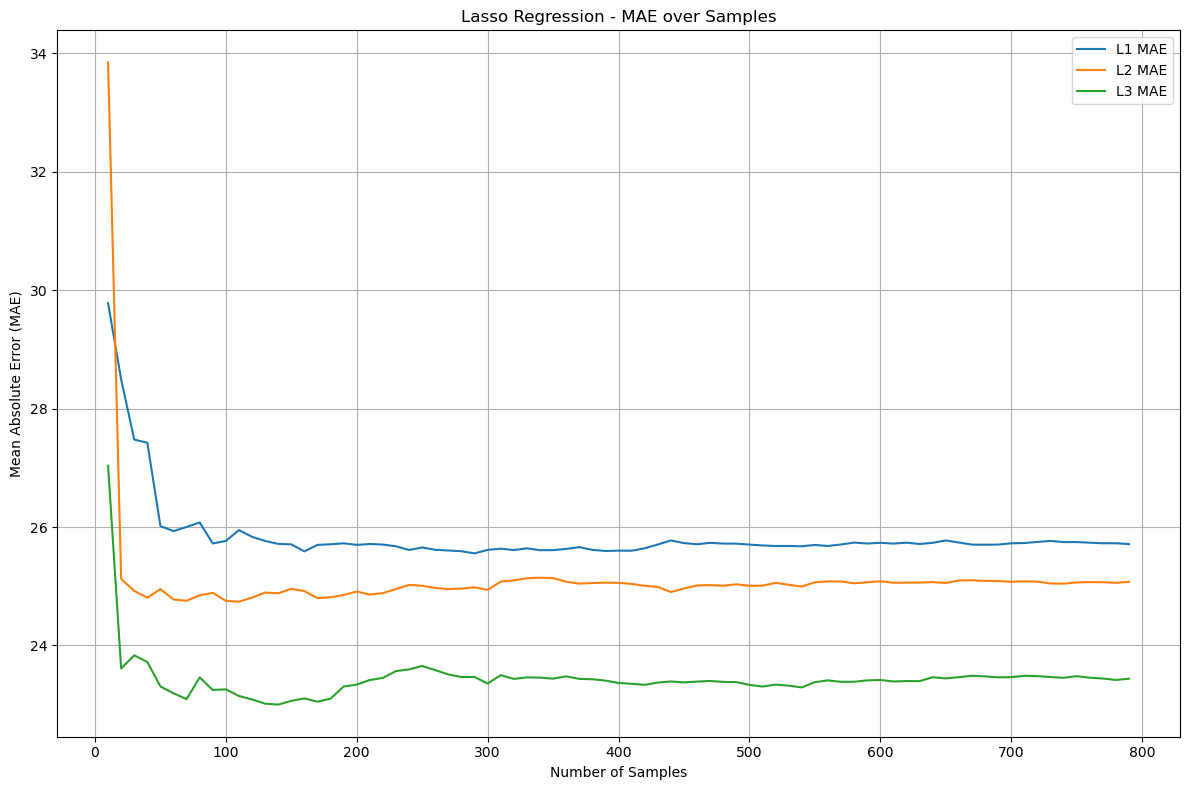

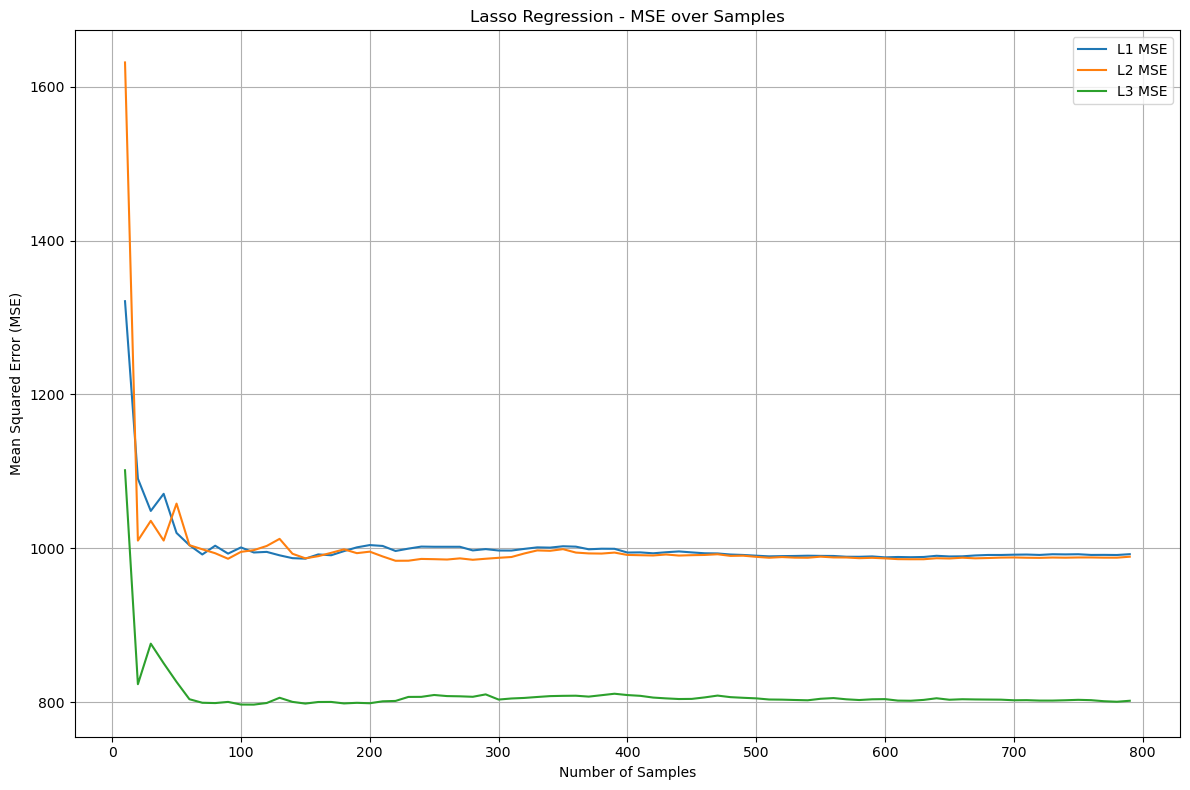

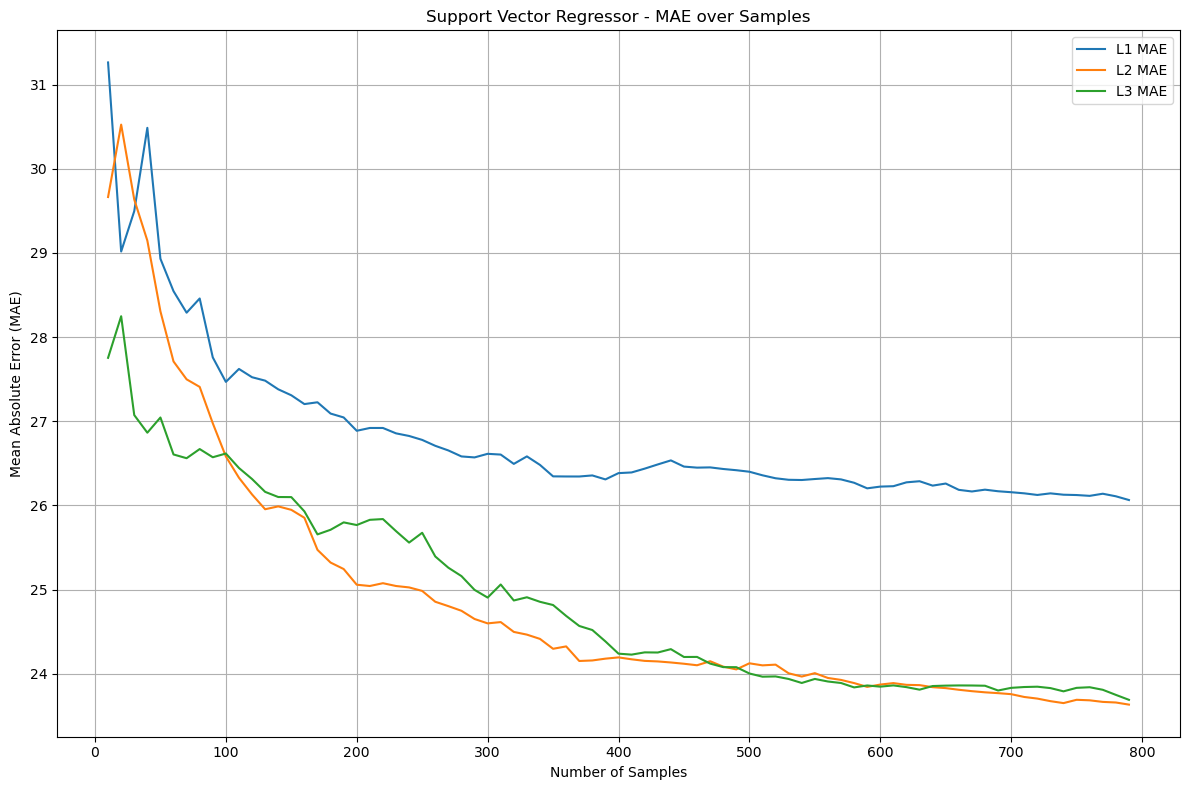

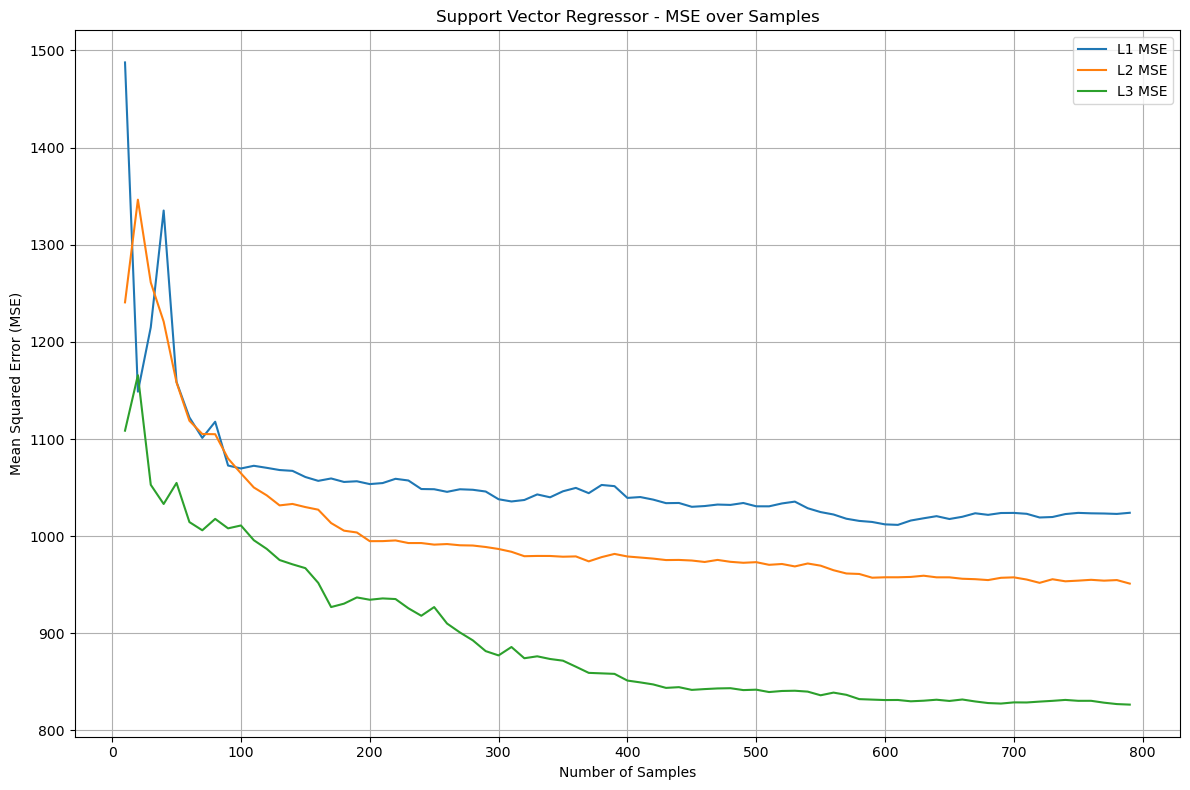

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


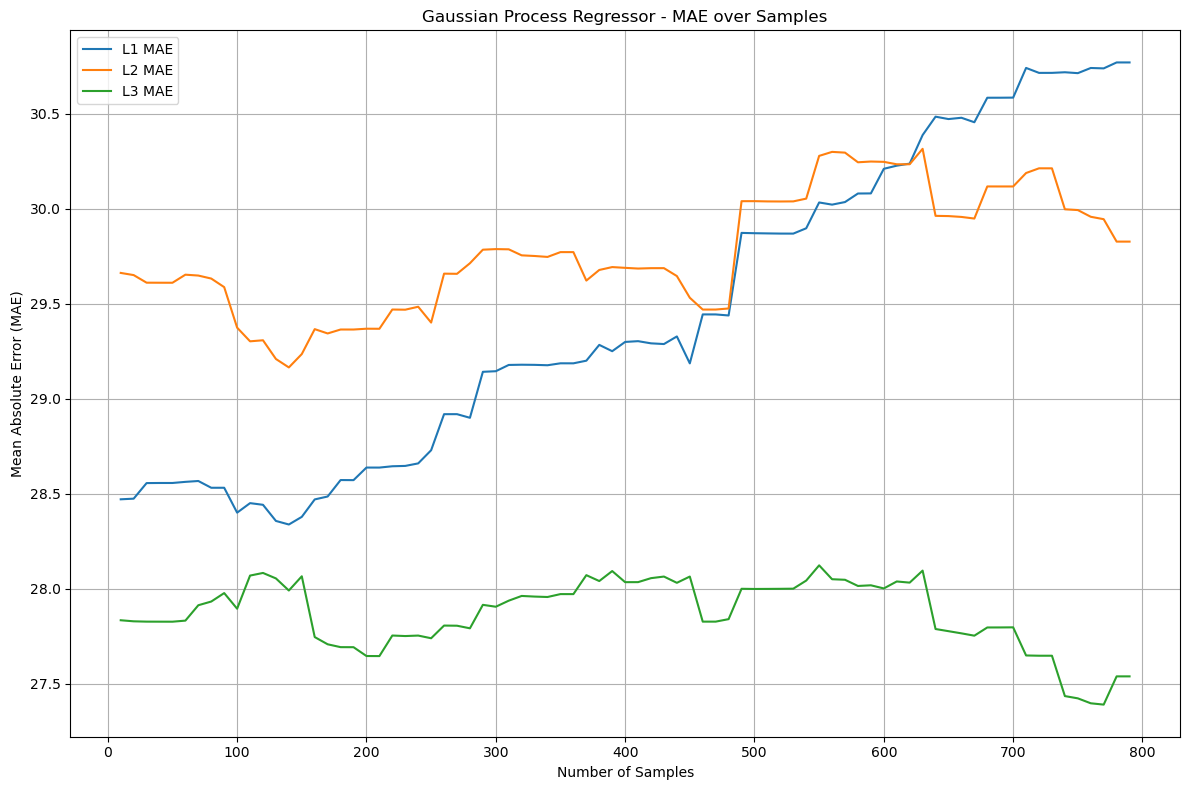

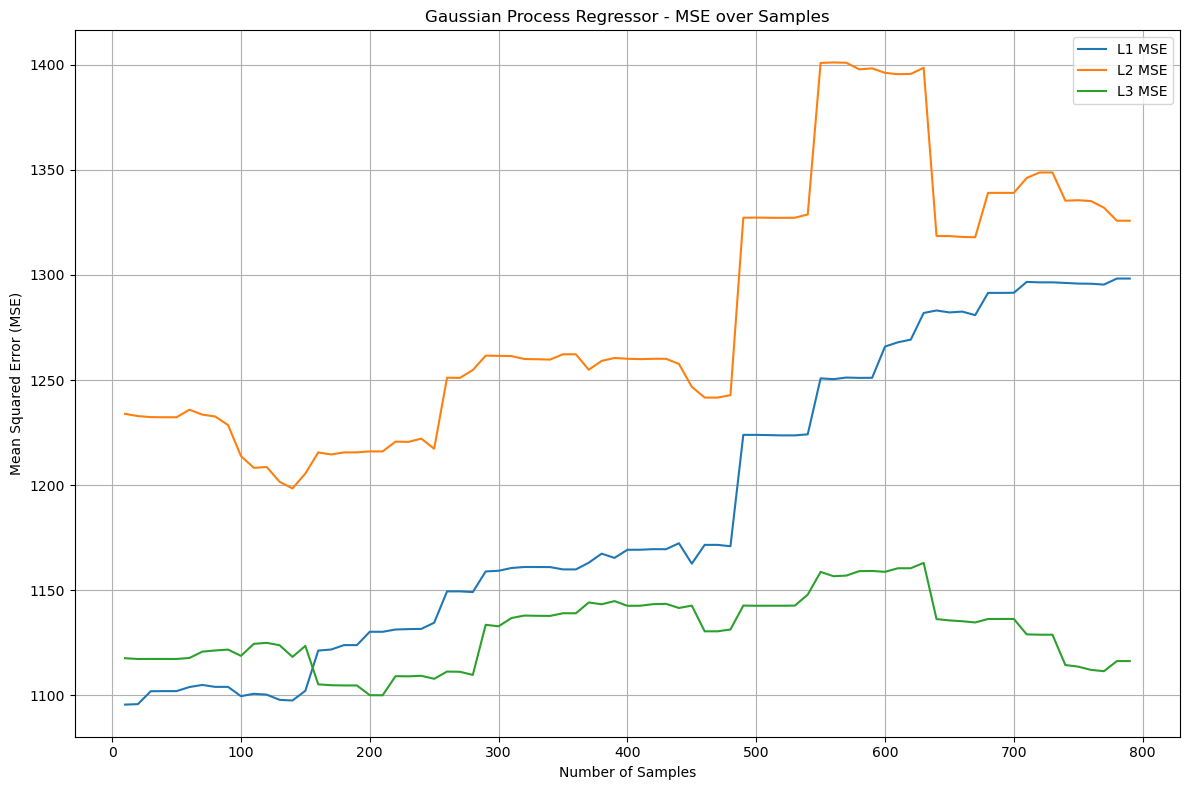

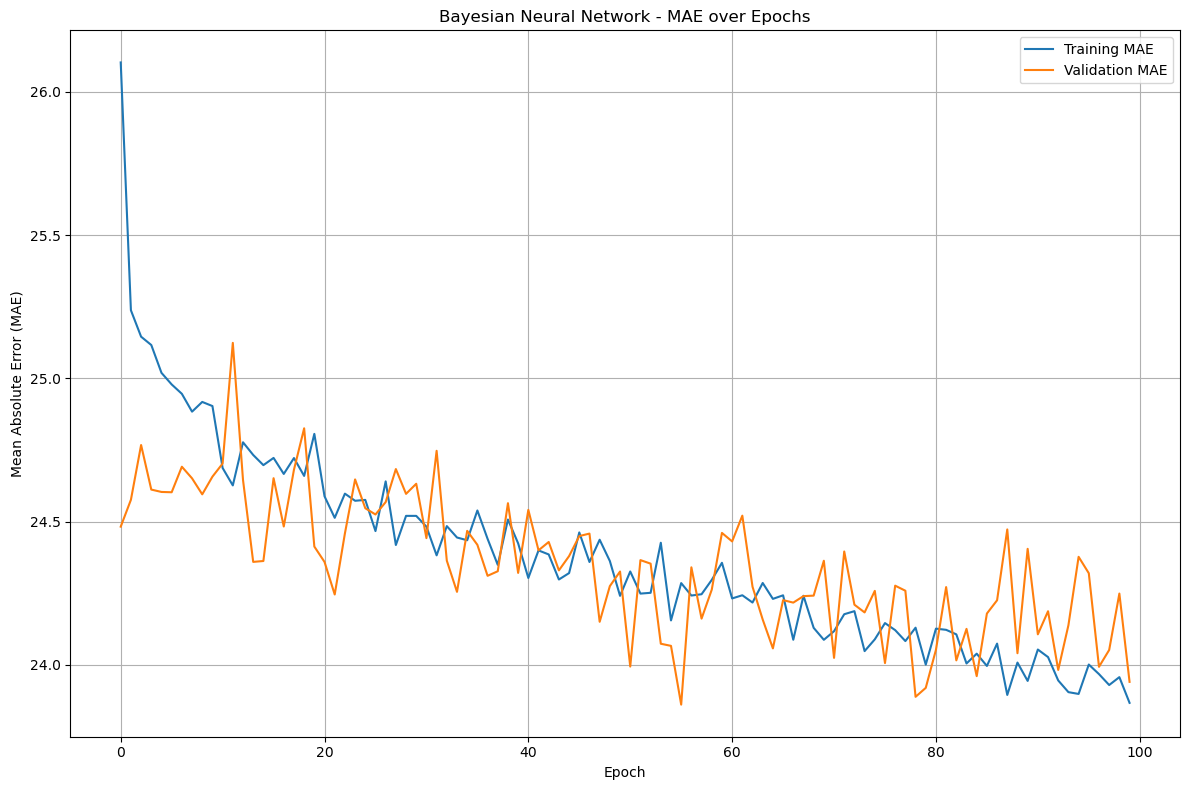

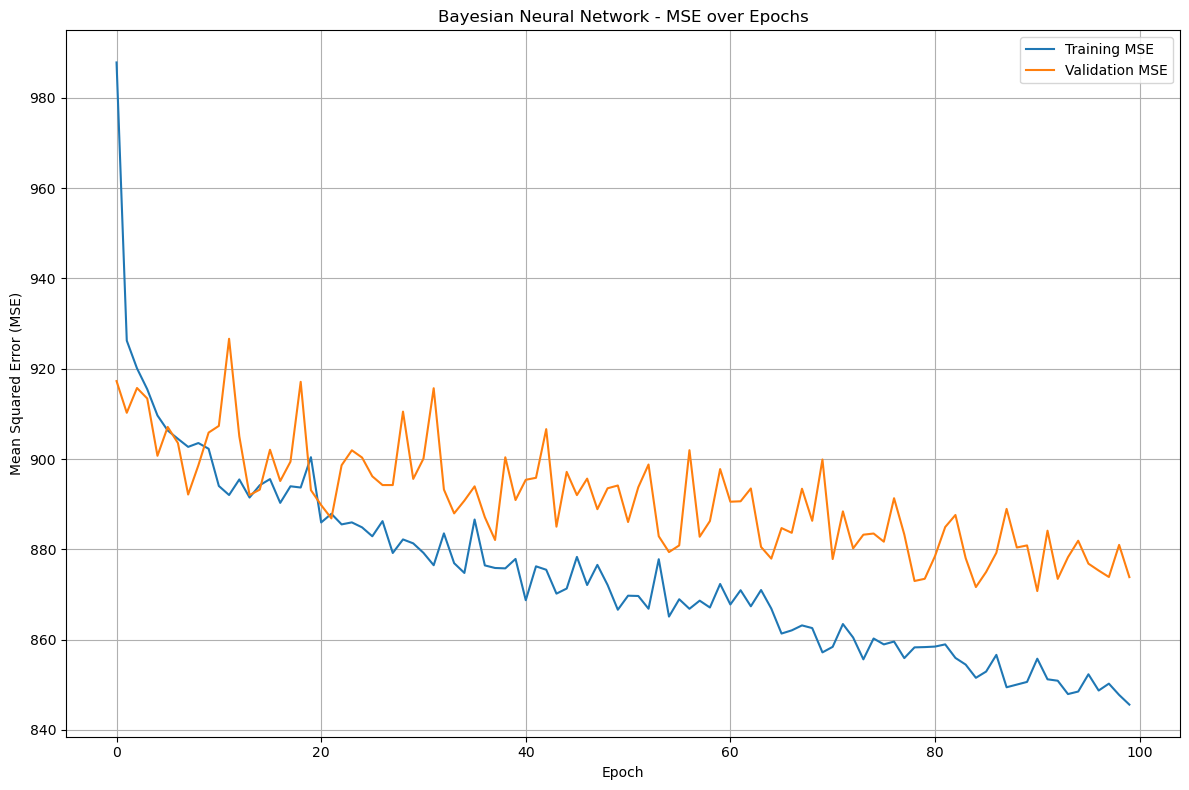

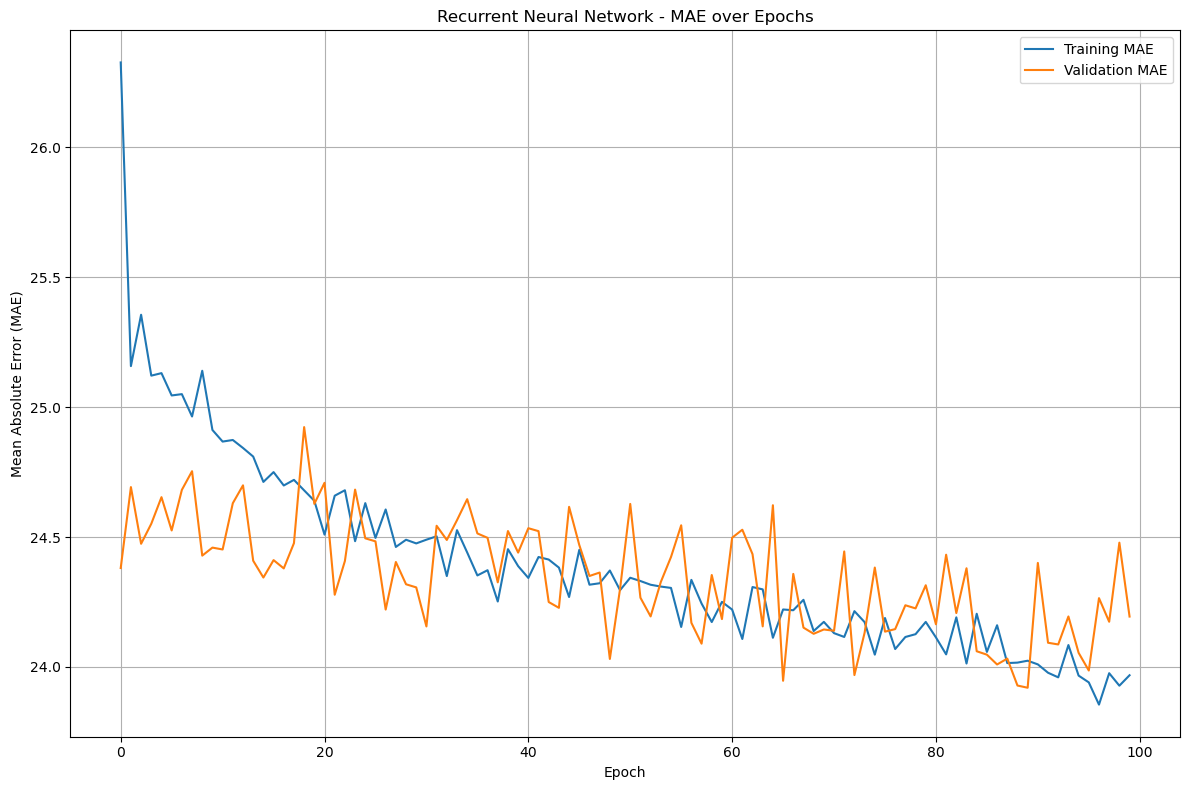

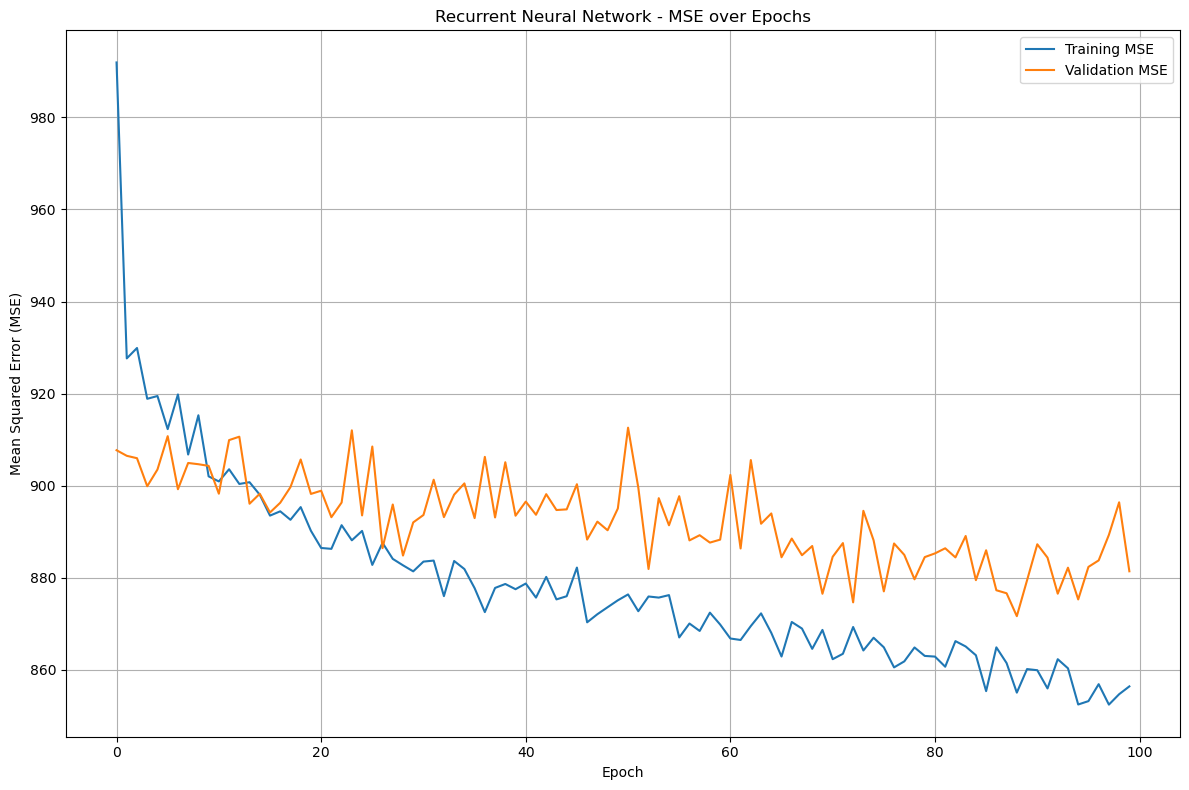

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Input
from tensorflow.keras.callbacks import History
import time

# Load the dataset
file_path = "D://_NYCU GIA//_Thesis//_gh//_data//training.csv"
data = pd.read_csv(file_path)

# Extract input and output columns
X = data[['α', 'β']]
y = data[['L1', 'L2', 'L3']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input data for RNN
X_train_rnn = np.expand_dims(X_train, axis=1)
X_test_rnn = np.expand_dims(X_test, axis=1)

# Define a function to build a simple Bayesian Neural Network
def build_bnn(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(3)  # Three outputs for L1, L2, L3
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Define a function to build a simple RNN
def build_rnn(input_dim):
    model = Sequential([
        Input(shape=(1, input_dim)),
        SimpleRNN(64, activation='relu', return_sequences=False),
        Dense(64, activation='relu'),
        Dense(3)  # Three outputs for L1, L2, L3
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Initialize models
models = {
    "Random Forest": MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    "Gradient Boosting": MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, random_state=42)),
    "Ridge Regression": MultiOutputRegressor(Ridge(alpha=1.0)),
    "Lasso Regression": MultiOutputRegressor(Lasso(alpha=0.1)),
    "Support Vector Regressor": MultiOutputRegressor(SVR()),
    "Bayesian Neural Network": build_bnn(X_train.shape[1]),
    "Recurrent Neural Network": build_rnn(X_train.shape[1]),
    "Gaussian Process Regressor": MultiOutputRegressor(GaussianProcessRegressor())
}

results = []
history_dict = {}

# Train and evaluate each model
for name, model in models.items():
    if name in ["Bayesian Neural Network", "Recurrent Neural Network"]:
        history = History()
        if name == "Bayesian Neural Network":
            model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0, validation_data=(X_test, y_test), callbacks=[history])
            y_pred = model.predict(X_test)
        elif name == "Recurrent Neural Network":
            model.fit(X_train_rnn, y_train, epochs=100, batch_size=10, verbose=0, validation_data=(X_test_rnn, y_test), callbacks=[history])
            y_pred = model.predict(X_test_rnn)
        history_dict[name] = history
    else:
        mse_l1_list, mae_l1_list = [], []
        mse_l2_list, mae_l2_list = [], []
        mse_l3_list, mae_l3_list = [], []

        for i in range(10, len(X_train), 10):
            model.fit(X_train[:i], y_train[:i])
            y_pred = model.predict(X_test)
            
            mse_l1 = mean_squared_error(y_test['L1'], y_pred[:, 0])
            mae_l1 = mean_absolute_error(y_test['L1'], y_pred[:, 0])
            mse_l2 = mean_squared_error(y_test['L2'], y_pred[:, 1])
            mae_l2 = mean_absolute_error(y_test['L2'], y_pred[:, 1])
            mse_l3 = mean_squared_error(y_test['L3'], y_pred[:, 2])
            mae_l3 = mean_absolute_error(y_test['L3'], y_pred[:, 2])
            
            mse_l1_list.append(mse_l1)
            mae_l1_list.append(mae_l1)
            mse_l2_list.append(mse_l2)
            mae_l2_list.append(mae_l2)
            mse_l3_list.append(mse_l3)
            mae_l3_list.append(mae_l3)
        
        # Plot MAE over samples
        plt.figure(figsize=(12, 8))
        plt.plot(range(10, len(X_train), 10), mae_l1_list, label='L1 MAE')
        plt.plot(range(10, len(X_train), 10), mae_l2_list, label='L2 MAE')
        plt.plot(range(10, len(X_train), 10), mae_l3_list, label='L3 MAE')
        plt.xlabel('Number of Samples')
        plt.ylabel('Mean Absolute Error (MAE)')
        plt.title(f'{name} - MAE over Samples')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"fig_evaluation_{name.replace(' ', '_')}_MAE_over_samples.png")
        plt.show()
        
        # Plot MSE over samples
        plt.figure(figsize=(12, 8))
        plt.plot(range(10, len(X_train), 10), mse_l1_list, label='L1 MSE')
        plt.plot(range(10, len(X_train), 10), mse_l2_list, label='L2 MSE')
        plt.plot(range(10, len(X_train), 10), mse_l3_list, label='L3 MSE')
        plt.xlabel('Number of Samples')
        plt.ylabel('Mean Squared Error (MSE)')
        plt.title(f'{name} - MSE over Samples')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"fig_evaluation_{name.replace(' ', '_')}_MSE_over_samples.png")
        plt.show()

# Plot accuracy over time for models with epochs
for name, history in history_dict.items():
    # Plot MAE over epochs
    plt.figure(figsize=(12, 8))
    plt.plot(history.epoch, history.history['mae'], label='Training MAE')
    plt.plot(history.epoch, history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title(f'{name} - MAE over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"fig_evaluation_{name.replace(' ', '_')}_MAE_over_epochs.png")
    plt.show()
    
    # Plot MSE over epochs
    plt.figure(figsize=(12, 8))
    plt.plot(history.epoch, history.history['loss'], label='Training MSE')
    plt.plot(history.epoch, history.history['val_loss'], label='Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title(f'{name} - MSE over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"fig_evaluation_{name.replace(' ', '_')}_MSE_over_epochs.png")
    plt.show()